# Imports

In [1]:
import os
import sys
import copy
import glob
import tqdm
from torch import nn
import random
import torch
import platform
from typing import Callable, List, Optional, Dict
import numpy as np
import scipy.sparse as sp

import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer, AutoModel

import torch_geometric
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    Batch
    )
import torch_geometric.datasets as datasets
import torch_geometric.transforms as transforms
from torch_geometric.data import Data
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, silhouette_score

# To ensure determinism
seed = 1234
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed)

# Check versions
print(torch.__version__)
print(torch.version.cuda)
print(platform.python_version())
print(torch_geometric.__version__)

/home/siddharthsa/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1.8.1+cu101
10.1
3.8.18
1.7.0


# Get Embedding from CodeBERT

In [2]:
import gc

#Set GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4,5"
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# Initialize the models
codebert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = AutoModel.from_pretrained("microsoft/codebert-base")
codebert_model = codebert_model.to(device)
max_source_length= 512

def get_code_embeddings_from_codebert(codelines):
    gc.collect()
    torch.cuda.empty_cache()
    code = " ".join(codelines)
    source_tokens = codebert_tokenizer.tokenize(code)[:max_source_length-2]
    source_tokens = [codebert_tokenizer.cls_token]+source_tokens+[codebert_tokenizer.sep_token]
    source_ids =  codebert_tokenizer.convert_tokens_to_ids(source_tokens) 
    padding_length = max_source_length - len(source_ids)
    source_ids+=[codebert_tokenizer.pad_token_id]*padding_length
    source_ids = torch.tensor(source_ids)
    
    # tokens = []
    # for code_line in codelines:
    #     code_tokens = codebert_tokenizer.tokenize(code_line, truncation=True, max_length=510)
    #     if tokens == []:
    #         tokens = [codebert_tokenizer.cls_token] + code_tokens
    #     else:
    #         tokens = tokens + [codebert_tokenizer.sep_token] + code_tokens
    # tokens = tokens + [codebert_tokenizer.eos_token]
    # tokens_ids = torch.tensor(codebert_tokenizer.convert_tokens_to_ids(tokens))
    source_ids = source_ids.to(device)
    context_embeddings = codebert_model(source_ids[None,:])
    cls_token_embedding = context_embeddings.last_hidden_state[0,0,:]
    return cls_token_embedding

# Get Embedding from UnixCoder

In [3]:
import gc
from unixcoder import UniXcoder

#Set GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4,5"
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# Initialize the models
unixcoder_model = UniXcoder("microsoft/unixcoder-base")
unixcoder_model = unixcoder_model.to(device)
max_source_length= 512

def get_code_embeddings_from_unixcoder(codelines):
    gc.collect()
    torch.cuda.empty_cache()
    code = " ".join(codelines)
    tokens_ids = unixcoder_model.tokenize([code], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    tokens_embeddings, code_embedding = unixcoder_model(source_ids)
    return torch.flatten(code_embedding)

In [4]:
def get_embeddings_from_llms(file_location, model):
    fp = open(file_location,'r')
    lines = fp.readlines()
    lines = [line for line in lines if not line.startswith("import") and not len(line.strip('\n')) == 0]
    lines = [line.strip('\n').strip(" ") for line in lines]
    if model == "codebert":
        embedding = get_code_embeddings_from_codebert(lines)
    elif model == "unixcoder":
        embedding = get_code_embeddings_from_unixcoder(lines)
    embedding = embedding.cpu().detach().numpy()
    return embedding

# Get Embedding from MuGNN

In [5]:
def get_nodes_edges(inTextFile, add_reverse_edges = False):
  # FD = 0, CD = 1
  # to support the hetero data object as suggested by the documentation 
  nodes_dict = {}
  edge_indices_CD = []
  edge_indices_FD = []

  #to support the Data object as used by the Entities dat object as used in RGAT source code
  edge_indices = []
  edge_type = []
  
  # nodes_dict is an index_map
  node_count=0
  with open(inTextFile) as fp:
    
    file_name = inTextFile.split("/")[-1].strip()

    Lines = fp.readlines()
    for line in Lines:

      N = line.split('-->')
      N[0], N[1] = N[0].strip(), N[1].strip()
      
      #t1 = N[0].split('$$')   
      src = N[0].strip()   
      if src not in nodes_dict.keys():
        nodes_dict[src] = node_count
        node_count+=1
        
      #t2 = N[1].split('$$')
      right_idx = N[1].rfind('[')
      dst = N[1][:right_idx].strip()
      if dst not in nodes_dict.keys():
        nodes_dict[dst] = node_count
        node_count+=1

      x = N[1].strip()[right_idx + 1 : -1].strip()
      if(x == 'FD'):
        y=0
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        if add_reverse_edges:
          edge_type.append(y)
          edge_indices.append([nodes_dict[dst], nodes_dict[src]])
        edge_indices_FD.append([nodes_dict[src], nodes_dict[dst]])
      else: 
        y=1
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        if add_reverse_edges:
          edge_type.append(y)
          edge_indices.append([nodes_dict[dst], nodes_dict[src]])
        edge_indices_CD.append([nodes_dict[src], nodes_dict[dst]])
     
  return nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type, file_name

In [6]:
#Set GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# Initialize the models
codebert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = AutoModel.from_pretrained("microsoft/codebert-base")
codebert_model = codebert_model.to(device)

def get_node_embedding_from_codebert(nodes):
    list_of_embeddings = []
    for code_line in nodes.keys():
        code_line = code_line.split("$$")[1].strip()
        code_tokens = codebert_tokenizer.tokenize(code_line, truncation=True, max_length=510)
        tokens = [codebert_tokenizer.cls_token]+code_tokens+[codebert_tokenizer.eos_token]
        tokens_ids = torch.tensor(codebert_tokenizer.convert_tokens_to_ids(tokens))
        tokens_ids = tokens_ids.to(device)
        context_embeddings = codebert_model(tokens_ids[None,:])
        cls_token_embedding = context_embeddings.last_hidden_state[0,0,:]
        list_of_embeddings.append(cls_token_embedding)
    return torch.stack(list_of_embeddings)

In [7]:
def get_graph_data(pdg_file_location, id):
    try:
        nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type, file_name = get_nodes_edges(pdg_file_location, add_reverse_edges = True)
    except Exception as e:
        print("\nError: ", e)
                    
    if(len(nodes_dict) == 0):
        print("\nNo Data: ", pdg_file_location)
    #print(nodes_dict, edge_indices_CD, edge_indices_FD, edge_type)

    # Node feature matrix with shape [num_nodes, num_node_features]=(N, 768).
    try:
        CodeEmbedding = get_node_embedding_from_codebert(nodes_dict)
    except Exception as e :
        print("\nError: ", e)
        print(nodes_dict)
    #print(CodeEmbedding.shape)

    # FIXING DATA FOTMATS AND SHAPE
    x = torch.tensor(CodeEmbedding)
    # print(x.shape)
  
    # data.y: Target to train against (may have arbitrary shape),
    # graph-level targets of shape [1, *]
    label = 1
    y = torch.tensor([label], dtype=torch.long)
    #print(type(y))

    # edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]
    edge_index_CD = torch.tensor(edge_indices_CD, dtype=torch.long).t().contiguous()
    edge_index_FD = torch.tensor(edge_indices_FD, dtype=torch.long).t().contiguous()
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_type, dtype=torch.long).t().contiguous()
    #print(edge_index_CD, edge_index_FD, edge_index, edge_type)
  
    data = Data(edge_index=edge_index, edge_attr=edge_attr, x=x)
    data.id = torch.tensor([id])
    data.y = y
    # data.num_nodes = len(nodes_dict)
    data.api = file_name
    
    return data

In [8]:
data = get_graph_data("/home/siddharthsa/cs21mtech12001-Tamal/API-Misuse-Prediction/PDG-gen/Repository/Benchmarks/Big-Clone-Bench/processed_pdg_data/2450_NA_NA_graph_dump.txt", 74)

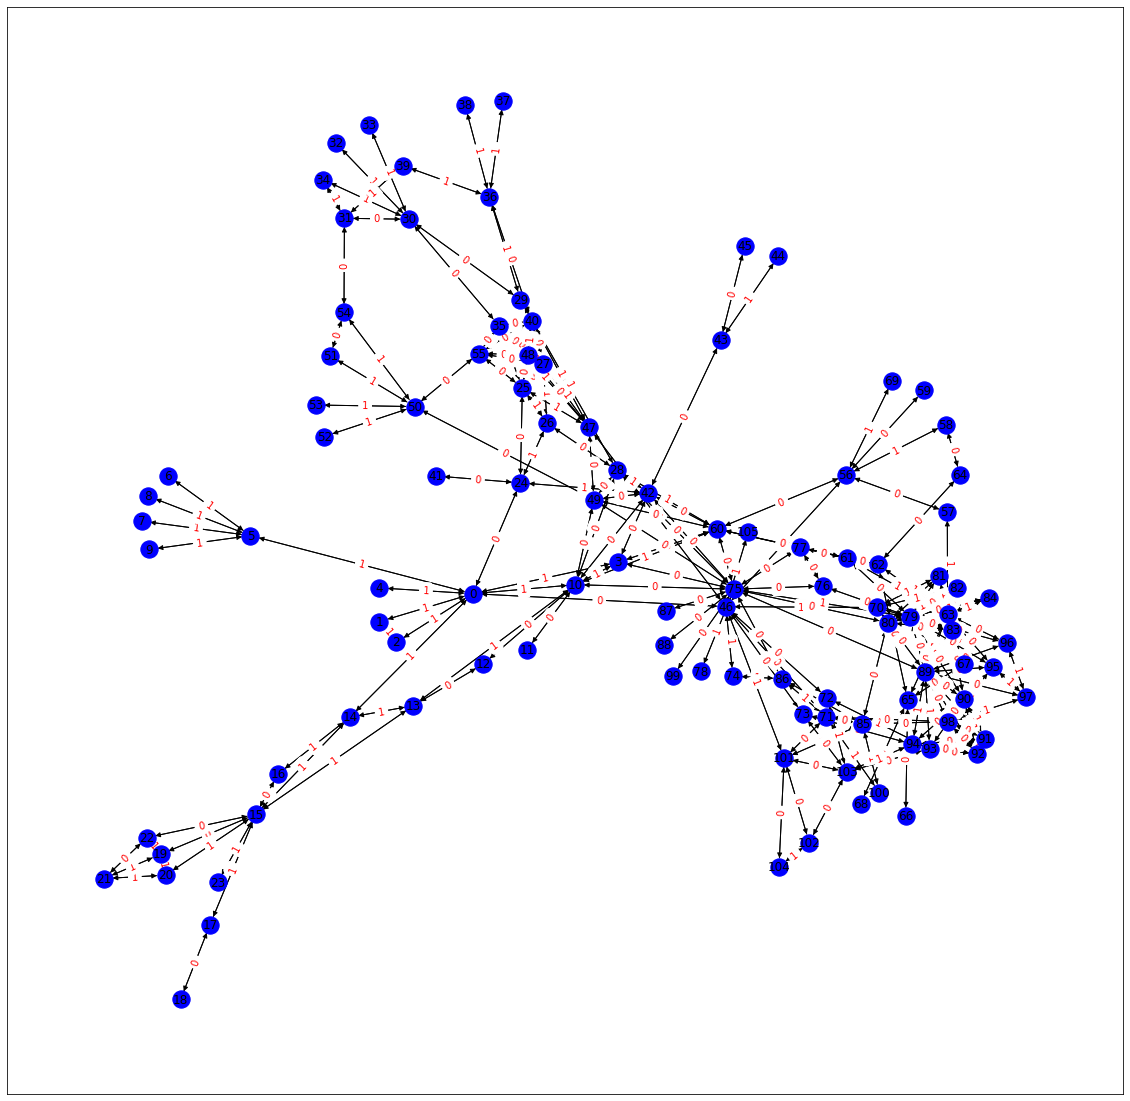

In [9]:
def visualize_graph(data, color):
    G = to_networkx(data, to_undirected=False)
    edge_labels = {}
    for i in range(len(G.edges)):
        edge = list(G.edges)[i]
        edge_labels[edge[0], edge[1]] = int(data.edge_attr[i])
    plt.figure(figsize=(20, 20))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G, seed=42), edge_labels=edge_labels, font_color='red')
    plt.show()

visualize_graph(data, color="blue")

## Build/Load MuGNN Model

In [10]:
from model import GNN, GNN_graphpred

#set up model
num_layer = 3
emb_dim = 768
gnn_type = "gcn"
num_tasks = 1
JK = "last"
dropout_ratio = 0.5
graph_pooling = "mean"
input_model_file = "/home/siddharthsa/cs21mtech12001-Tamal/API-Misuse-Prediction/PDG-gen/Repository/Graph-Models/MuGNN/output/saved_models/gcn_1_3_5_e100_model_ck_code2seq.pth"

gnn_graphpred_model = GNN_graphpred(num_layer, emb_dim, num_tasks, JK = JK, drop_ratio = dropout_ratio, graph_pooling = graph_pooling, gnn_type = gnn_type)
gnn_graphpred_model.from_pretrained(input_model_file)

gnn_model = GNN(num_layer, emb_dim, JK, drop_ratio = dropout_ratio, gnn_type = gnn_type)
gnn_model.load_state_dict(torch.load(input_model_file))

print("Loaded the model!!")

Loaded the model!!


In [11]:
def get_embeddings_from_mugnn(pdg_file_location, id):
    data = get_graph_data(pdg_file_location, id)
    node_representation = gnn_model(data.x, data.edge_index, data.edge_attr)
    graph_representation = global_mean_pool(x = node_representation, batch = torch.tensor([0]*(len(node_representation))))[0]
    data.embedding = graph_representation.detach().numpy()
    return data.embedding

# Check Embedding Similarity

In [12]:
import os
from sklearn.metrics.pairwise import cosine_similarity

mapping_file = open('/home/siddharthsa/cs21mtech12001-Tamal/API-Misuse-Prediction/PDG-gen/Repository/Benchmarks/Big-Clone-Bench/raw_dataset/test.txt', 'r')
datapoints = mapping_file.readlines()

JAVA_FOLDER_PATH = "/home/siddharthsa/cs21mtech12001-Tamal/API-Misuse-Prediction/PDG-gen/Repository/Benchmarks/Big-Clone-Bench/java_files"
PDG_FOLDER_PATH = "/home/siddharthsa/cs21mtech12001-Tamal/API-Misuse-Prediction/PDG-gen/Repository/Benchmarks/Big-Clone-Bench/processed_pdg_data"
OUTPUT_TEXT_FILE = "/home/siddharthsa/cs21mtech12001-Tamal/API-Misuse-Prediction/PDG-gen/Repository/Graph-Models/MuGNN/temp/clone-detection-result.txt"

output_file = open(OUTPUT_TEXT_FILE, "w")
positive_count, negative_count = 0, 0

for data in datapoints:
    
    id1, id2, label = data.strip().split("\t")
    if positive_count == 50 and negative_count == 50:
        break
    if(label == "1"):
        if positive_count == 50:
            continue
    else:
        if negative_count == 50:
            continue
        
    java_code_1_path = JAVA_FOLDER_PATH + "/" + id1 + ".java"
    java_code_2_path = JAVA_FOLDER_PATH + "/" + id2 + ".java"
    pdg_code_1_path = PDG_FOLDER_PATH + "/" + id1 + "_NA_NA_graph_dump.txt"
    pdg_code_2_path = PDG_FOLDER_PATH + "/" + id2 + "_NA_NA_graph_dump.txt"
    if(os.path.exists(java_code_1_path) and os.path.exists(java_code_2_path) and os.path.exists(pdg_code_1_path) and os.path.exists(pdg_code_2_path)):
        
        code_1_codebert_embedding = get_embeddings_from_llms(java_code_1_path, "codebert")
        code_1_unixcoder_embedding = get_embeddings_from_llms(java_code_1_path, "unixcoder")
        code_1_mugnn_embedding = get_embeddings_from_mugnn(pdg_code_1_path, int(id1))
        
        code_2_codebert_embedding = get_embeddings_from_llms(java_code_2_path, "codebert")
        code_2_unixcoder_embedding = get_embeddings_from_llms(java_code_2_path, "unixcoder")
        code_2_mugnn_embedding = get_embeddings_from_mugnn(pdg_code_2_path, int(id2))
        
        codebert_similarity = cosine_similarity(code_1_codebert_embedding.reshape(1, -1), code_2_codebert_embedding.reshape(1, -1))
        unixcoder_similarity = cosine_similarity(code_1_unixcoder_embedding.reshape(1, -1), code_2_unixcoder_embedding.reshape(1, -1))
        mugnn_similarity = cosine_similarity(code_1_mugnn_embedding.reshape(1, -1), code_2_mugnn_embedding.reshape(1, -1))
        result = f"{id1}, {id2}, {label}, {codebert_similarity[0][0]}, {unixcoder_similarity[0][0]}, {mugnn_similarity[0][0]}\n"
        output_file.write(result)
        
        if(label == "1"):
            positive_count += 1
        else:
            negative_count += 1
            
        print("Positive processed: {} and Negative Processed: {}".format(positive_count, negative_count))
        
output_file.close()

Positive processed: 0 and Negative Processed: 1
Positive processed: 0 and Negative Processed: 2
Positive processed: 0 and Negative Processed: 3
Positive processed: 0 and Negative Processed: 4
Positive processed: 0 and Negative Processed: 5
Positive processed: 0 and Negative Processed: 6


Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors


Positive processed: 0 and Negative Processed: 7
Positive processed: 0 and Negative Processed: 8
Positive processed: 0 and Negative Processed: 9
Positive processed: 0 and Negative Processed: 10
Positive processed: 1 and Negative Processed: 10
Positive processed: 2 and Negative Processed: 10
Positive processed: 2 and Negative Processed: 11
Positive processed: 2 and Negative Processed: 12
Positive processed: 2 and Negative Processed: 13
Positive processed: 2 and Negative Processed: 14
Positive processed: 2 and Negative Processed: 15
Positive processed: 2 and Negative Processed: 16
Positive processed: 2 and Negative Processed: 17
Positive processed: 2 and Negative Processed: 18
Positive processed: 2 and Negative Processed: 19
Positive processed: 3 and Negative Processed: 19
Positive processed: 3 and Negative Processed: 20
Positive processed: 3 and Negative Processed: 21
Positive processed: 3 and Negative Processed: 22
Positive processed: 3 and Negative Processed: 23
Positive processed: 3 a

In [8]:

OUTPUT_TEXT_FILE_1 = "/home/siddharthsa/cs21mtech12001-Tamal/API-Misuse-Prediction/PDG-gen/Repository/Graph-Models/MuGNN/temp/clone-detection-result.txt"
OUTPUT_TEXT_FILE_2 = "/home/siddharthsa/cs21mtech12001-Tamal/API-Misuse-Prediction/PDG-gen/Repository/Graph-Models/MuGNN/temp/clone-detection-result-sorted.txt"

output_file = open(OUTPUT_TEXT_FILE_1, "r")
result = []

for line in output_file.readlines():
    id1, id2, label, cb, un, gnn = line.split(",")
    id1 = int(id1.strip())
    id2 = int(id2.strip())
    label = int(label.strip())
    cb = float(cb.strip())
    un = float(un.strip())
    gnn = float(gnn.strip().strip("\n"))
    result.append([id1, id2, label, cb, un, gnn])
    
output_file.close()

result.sort(key=lambda x: x[5], reverse = True)

output_file = open(OUTPUT_TEXT_FILE_2, "w")
for res in result:
    res_str = f"{res[0]}, {res[1]}, {res[2]}, {res[3]}, {res[4]}, {res[5]}\n"
    output_file.write(res_str)
output_file.close()
